In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_Internal_Memory)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"
    data['Num_cores'] = data['Num_cores'].apply(lambda x: "Other" if x in ("312", "Tru-Octa") else x)

    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"
    data['os_name'] = data['os_name'].apply(lambda x: "Other" if x in ("Blackberry","Nokia","KAI", "Tizen") else x)
    
    data['Brand'] = data['Brand'].apply(for_string)
    data['Brand'][data['Brand'] == "OPPO"] = "Oppo"
    data['Brand'][data['Brand'] == "Moto"] = "Motorola"
    data['Brand'] = data['Brand'].apply(lambda x: "Other" if x in ("Billion","Comio","Do","Infinix",
                                            "Itel","Jivi","Mobiistar","Nubia","Tecno","Ulefone",
                                            "Lephone","VOTO","iVooMi","LeEco","Lyf","Razer","Yu") else x)
    

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Capacity', 'Pixel Density', 'SIM Slot(s)',
       'Internal Memory', 'Resolution', 'os_name', 'Screen Size',
       'Screen to Body Ratio (calculated)', 'Num_cores', 'Brand', 'RAM',
       'Processor_frequency', 'Weight', 'Height', 'SIM 2', 'Sim1'],
      dtype='object')
(460, 62)
Index(['PhoneId', 'Capacity', 'Pixel Density', 'Internal Memory', 'Resolution',
       'Screen Size', 'Screen to Body Ratio (calculated)', 'RAM',
       'Processor_frequency', 'Weight', 'Height',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'os_name_Android', 'os_name_Other',
       'os_name_iOS', 'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa',
       'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad', 'Brand_10.or',
       'Brand_Apple', 'Brand_Asus', 'Brand_Blackberry', 'Brand_Coolpad',
       'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',


In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 63
Number of data points in test: 119
Number of features in test: 62


In [15]:
train_new.head()

,PhoneId,Capacity,Pixel Density,Internal Memory,Resolution,Screen Size,Screen to Body Ratio (calculated),RAM,Processor_frequency,Weight,Height,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Other,os_name_iOS,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Blackberry,Brand_Coolpad,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Intex,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_Lenovo,Brand_Meizu,Brand_Micromax,Brand_Motorola,Brand_Nokia,Brand_OnePlus,Brand_Oppo,Brand_Other,Brand_Panasonic,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Vivo,Brand_Xiaomi,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Rating
0,0,4000,403,64,20,6.26,80.68,4,1.8,182,157.9,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,4.5
1,1,4230,271,32,8,6.20,80.85,3,1.8,168,156.2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.5
2,2,3500,409,32,25,6.30,83.68,3,2.1,168,157.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4
3,4,3300,411,64,24,6.00,74.78,4,2.2,169,159.8,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,4.3
4,5,3750,396,64,16,6.50,84.23,4,2.2,175,160.4,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4


In [16]:
test_new.head()

,PhoneId,Capacity,Pixel Density,Internal Memory,Resolution,Screen Size,Screen to Body Ratio (calculated),RAM,Processor_frequency,Weight,Height,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Other,os_name_iOS,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Blackberry,Brand_Coolpad,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Intex,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_Lenovo,Brand_Meizu,Brand_Micromax,Brand_Motorola,Brand_Nokia,Brand_OnePlus,Brand_Oppo,Brand_Other,Brand_Panasonic,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Vivo,Brand_Xiaomi,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G
0,3,4230,271,16,5,6.20,80.85,2,1.8,168,156.2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,11,5000,402,64,12,6.20,81.60,4,1.8,205,156.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,13,3500,409,64,25,6.30,83.84,6,2.0,169,156.7,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,16,3500,409,64,16,6.30,83.84,4,2.0,169,156.7,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,19,4000,403,64,20,5.99,77.43,4,1.8,181,158.6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


## Dummy Solution

In [17]:
from numpy import mean, std, percentile
def mean_outliers(data):
    # calculate summary statistics
    data_mean, data_std = data.mean(), std(data)
    print('\nMean: %.3f, Std: %.3f' %(data_mean, data_std))
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print('Lower: %.3f, Upper: %.3f' %(lower, upper))
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    print(outliers)
    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers

def iqr_outliers(data):
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('\nPercentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower: %.3f, Upper: %.3f' %(lower, upper))
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    print(outliers)
    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers

outliers = mean_outliers(train_new['Capacity'])
outliers = mean_outliers(test_new['Capacity'])

outliers = mean_outliers(train_new['Internal Memory'])
outliers = mean_outliers(test_new['Internal Memory'])
outliers = mean_outliers(train_new['Height'])
outliers = mean_outliers(test_new['Height'])
outliers = iqr_outliers(train_new['Screen to Body Ratio (calculated)'])
outliers = iqr_outliers(test_new['Screen to Body Ratio (calculated)'])


Mean: 3191.308, Std: 931.165
Lower: 397.812, Upper: 5984.803
Identified outliers: 1
[13000]
Non-outlier observations: 340

Mean: 3233.765, Std: 768.847
Lower: 927.224, Upper: 5540.306
Identified outliers: 0
[]
Non-outlier observations: 119

Mean: 46.370, Std: 46.367
Lower: -92.732, Upper: 185.471
Identified outliers: 5
[256, 256, 256, 512, 256]
Non-outlier observations: 336

Mean: 48.336, Std: 49.632
Lower: -100.560, Upper: 197.233
Identified outliers: 4
[256, 256, 256, 256]
Non-outlier observations: 115

Mean: 149.946, Std: 9.179
Lower: 122.410, Upper: 177.483
Identified outliers: 7
[118.0, 115.6, 118.0, 117.5, 120.0, 118.0, 116.4]
Non-outlier observations: 334

Mean: 150.278, Std: 8.480
Lower: 124.837, Upper: 175.718
Identified outliers: 2
[124.0, 111.5]
Non-outlier observations: 117

Percentiles: 25th=68.800, 75th=77.480, IQR=8.680
Lower: 55.780, Upper: 90.500
Identified outliers: 9
[28.26, 23.6, 30.11, 30.26, 30.11, 33.3, 35.3, 29.59, 30.49]
Non-outlier observations: 332

Percenti

In [18]:
train_new['Rating'] = train_new['Rating'].map(lambda x: 1 if x >= THRESHOLD else 0)

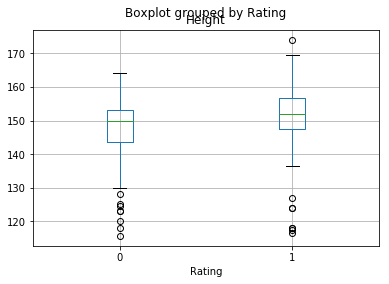

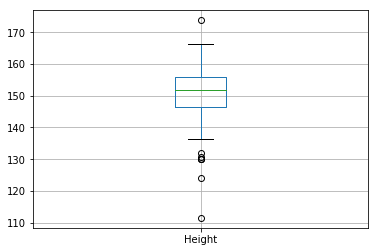

In [19]:
train_new.boxplot(column='Height', by='Rating')
plt.show()
test_new.boxplot(column='Height')

In [20]:
def remove_train_outliers(d):
    data = d.copy()
    
    data['Height'][data['Rating'] == 0] = data['Height'][data['Rating'] == 0].map(lambda x: 130 if x < 130 else x)
    data['Height'][data['Rating'] == 0] = data['Height'][data['Rating'] == 0].map(lambda x: 164 if x > 164 else x)
    data['Height'][data['Rating'] == 1] = data['Height'][data['Rating'] == 1].map(lambda x: 138 if x < 138 else x)
    data['Height'][data['Rating'] == 1] = data['Height'][data['Rating'] == 1].map(lambda x: 169 if x > 169 else x)
    
    data['Capacity'][data['Rating'] == 0] = data['Capacity'][data['Rating'] == 0].map(lambda x: 4100 if x > 4100 else x)
    data['Capacity'][data['Rating'] == 1] = data['Capacity'][data['Rating'] == 1].map(lambda x: 4500 if x > 4500 else x)
    data['Capacity'][data['Rating'] == 1] = data['Capacity'][data['Rating'] == 1].map(lambda x: 1900 if x < 1900 else x)
    
    data['Resolution'][data['Rating'] == 0] = data['Resolution'][data['Rating'] == 0].map(lambda x: 8 if x > 8 else x)
    
    data['Weight'][data['Rating'] == 0] = data['Weight'][data['Rating'] == 0].map(lambda x: 125 if x < 125 else x)
    data['Weight'][data['Rating'] == 0] = data['Weight'][data['Rating'] == 0].map(lambda x: 200 if x > 200 else x)
    data['Weight'][data['Rating'] == 1] = data['Weight'][data['Rating'] == 1].map(lambda x: 120 if x < 120 else x)
    data['Weight'][data['Rating'] == 1] = data['Weight'][data['Rating'] == 1].map(lambda x: 215 if x > 215 else x)
    
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].map(lambda x: 55 if x < 55 else x)
    
    data['Internal Memory'][data['Rating'] == 0] = data['Internal Memory'][data['Rating'] == 0].map(lambda x: 64 if x > 64 else x)
    data['Internal Memory'][data['Rating'] == 1] = data['Internal Memory'][data['Rating'] == 1].map(lambda x: 128 if x > 128 else x)
    
    data['Screen Size'] = data['Screen Size'].map(lambda x: 3.6 if x < 3.6 else x)
    
    data['RAM'][data['Rating'] == 0] = data['RAM'][data['Rating'] == 0].map(lambda x: 4 if x > 4 else x)
    data['RAM'][data['Rating'] == 1] = data['RAM'][data['Rating'] == 1].map(lambda x: 4 if x > 6 else x)
    
    return data

In [21]:
def remove_test_outliers(d):
    data = d.copy()
    
    data['Height'] = data['Height'].map(lambda x: 130 if x < 130 else x)
    data['Height'] = data['Height'].map(lambda x: 170 if x > 170 else x)
    
    data['Pixel Density'] = data['Pixel Density'].map(lambda x: 580 if x > 580 else x)
    
    data['Capacity'] = data['Capacity'].map(lambda x: 1900 if x < 1900 else x)
    data['Capacity'] = data['Capacity'].map(lambda x: 4500 if x > 4500 else x)
    
    data['Weight'] = data['Weight'].map(lambda x: 125 if x < 125 else x)
    data['Weight'] = data['Weight'].map(lambda x: 200 if x > 200 else x)
    
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].map(lambda x: 60 if x < 60 else x)
    
    data['Internal Memory'] = data['Internal Memory'].map(lambda x: 128 if x > 128 else x)
    
    data['Screen Size'] = data['Screen Size'].map(lambda x: 3.6 if x < 3.6 else x)
    
    data['RAM'] = data['RAM'].map(lambda x: 6 if x > 6 else x)
    
    data['Processor_frequency'] = data['Processor_frequency'].map(lambda x: 2.8 if x > 2.8 else x)
     
    return data

In [22]:
def normalize_data(d):
    data = d.copy()
    
    min = data['Height'].min()
    max = data['Height'].max()
    data['Height'] = data['Height'].map(lambda x: (x - min)/(max - min))
    
    min = data['Pixel Density'].min()
    max = data['Pixel Density'].max()
    data['Pixel Density'] = data['Pixel Density'].map(lambda x: (x - min)/(max - min))
    
    min = data['Capacity'].min()
    max = data['Capacity'].max()
    data['Capacity'] = data['Capacity'].map(lambda x: (x - min)/(max - min))
    
    min = data['Resolution'].min()
    max = data['Resolution'].max()
    data['Resolution'] = data['Resolution'].map(lambda x: (x - min)/(max - min))
    
    min = data['Weight'].min()
    max = data['Weight'].max()
    data['Weight'] = data['Weight'].map(lambda x: (x - min)/(max - min))
    
    min = data['Screen to Body Ratio (calculated)'].min()
    max = data['Screen to Body Ratio (calculated)'].max()
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].map(lambda x: (x - min)/(max - min))
    
    min = data['Internal Memory'].min()
    max = data['Internal Memory'].max()
    data['Internal Memory'] = data['Internal Memory'].map(lambda x: (x - min)/(max - min))
    
    min = data['Screen Size'].min()
    max = data['Screen Size'].max()
    data['Screen Size'] = data['Screen Size'].map(lambda x: (x - min)/(max - min))
    
    min = data['RAM'].min()
    max = data['RAM'].max()
    data['RAM'] = data['RAM'].map(lambda x:  (x - min)/(max - min))
    
    min = data['Processor_frequency'].min()
    max = data['Processor_frequency'].max()
    data['Processor_frequency'] = data['Processor_frequency'].map(lambda x: (x - min)/(max - min))
    
    return data

In [23]:
def normalize(col):
    min = col.min()
    max = col.max()
    
    col = col.map(lambda x: (x - min)/(max - min))
    return col   

In [25]:
X_train_out = remove_train_outliers(train_new)
X_train_new = X_train_out.drop(['PhoneId', 'Rating'], axis=1)
X_train_norm = normalize_data(X_train_new)
Y_train_new = train_new['Rating']

X_test_new = test_new.drop(['PhoneId'], axis=1)
X_test_new = remove_test_outliers(X_test_new)
X_test_norm = normalize_data(X_test_new)

X_train = X_train_norm.values
Y_train = Y_train_new.values
X_test = X_test_norm.values


In [26]:
X_train_norm
#X_test_norm
#Y_train.shape
#print(X_train_norm.shape)
#print(X_test_norm.shape)
#X_train_out.boxplot(column='Height', by='Rating')
#plt.show()
#X_test_new.boxplot(column='Height')

,Capacity,Pixel Density,Internal Memory,Resolution,Screen Size,Screen to Body Ratio (calculated),RAM,Processor_frequency,Weight,Height,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Other,os_name_iOS,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Blackberry,Brand_Coolpad,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Intex,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_Lenovo,Brand_Meizu,Brand_Micromax,Brand_Motorola,Brand_Nokia,Brand_OnePlus,Brand_Oppo,Brand_Other,Brand_Panasonic,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Vivo,Brand_Xiaomi,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G
0,0.848485,0.600462,0.5000,0.782609,0.889632,0.786283,0.666667,0.444444,0.652632,0.715385,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,0.918182,0.295612,0.2500,0.260870,0.869565,0.791488,0.500000,0.444444,0.505263,0.671795,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.696970,0.614319,0.2500,1.000000,0.903010,0.878138,0.500000,0.611111,0.505263,0.692308,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.636364,0.618938,0.5000,0.956522,0.802676,0.605634,0.666667,0.666667,0.515789,0.764103,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,0.772727,0.584296,0.5000,0.608696,0.969900,0.894979,0.666667,0.666667,0.578947,0.779487,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5,0.666667,0.598152,0.5000,1.000000,0.939799,0.917942,1.000000,0.666667,0.378947,0.715385,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
6,0.545455,0.351039,0.1250,0.130435,0.618729,0.541335,0.333333,0.555556,0.263158,0.448718,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
7,0.848485,0.667436,0.2500,0.130435,0.749164,0.742192,0.500000,0.555556,0.610526,0.494872,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
8,0.918182,0.295612,0.1250,0.260870,0.869565,0.791488,0.333333,0.444444,0.505263,0.671795,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9,0.848485,0.600462,0.5000,0.782609,0.862876,0.832823,1.000000,1.000000,0.652632,0.653846,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [27]:
"""
WRITE YOUR MODELLING CODE HERE
"""
class Perceptron:
    def __init__(self):
        self.w = None;
        self.b = None;
        
    def model(self, x):
        return 1 if (np.dot(self.w, x) >= self.b) else 0
    
    def predict(self, X):
        Y = []
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self, X, Y, epochs=1, lr=1):
        self.w = np.ones(X.shape[1])
        self.b = 0
        
        accuracy = {}
        max_accuracy = 0
        
        for i in range(epochs):
            for x, y in zip(X, Y):
                y_pred = self.model(x)
                if y == 1 and y_pred == 0:
                    self.w = self.w + lr*x
                    self.b = self.b + lr*1
                elif y == 0 and y_pred == 1:
                    self.w = self.w - lr*x
                    self.b = self.b - lr*1
            accuracy[i] = accuracy_score(self.predict(X), Y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
            
        self.w = chkptw
        self.b = chkptb
            
        print(max_accuracy)
        #print(accuracy.values())
        plt.plot(accuracy.values())
        plt.ylim([0, 1])
        plt.show()

In [28]:
perceptron = Perceptron()

0.8651026392961877


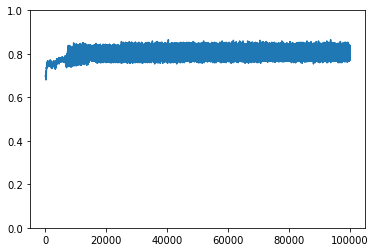

In [29]:
perceptron.fit(X_train, Y_train, 100000, 0.0001)

In [30]:
print(perceptron.w)
print(perceptron.b)
Y_test = perceptron.predict(X_test)
print(Y_test)

[ 7.87272727e-04 -3.63510393e-04  1.07812500e-03  1.22173913e-03
  1.23979933e-03 -1.12023882e-03 -5.83333333e-04  1.32777778e-04
 -9.22105263e-04  9.89478635e-05  1.00000000e+00 -2.49470000e+00
 -2.49470000e+00 -1.91200000e+00 -3.34220000e+00 -4.55920000e+00
  1.00000000e+00 -6.16800000e-01 -8.22100000e-01 -6.15400000e-01
 -6.15600000e-01 -6.15700000e-01 -6.15800000e-01  5.85600000e-01
  1.00000000e+00  5.87300000e-01  5.86100000e-01  5.85800000e-01
  5.86500000e-01  1.00000000e+00  5.86200000e-01  5.86900000e-01
  1.00000000e+00  5.85400000e-01  5.85700000e-01  5.85600000e-01
  5.86600000e-01  5.86900000e-01  5.86700000e-01  1.00550000e+00
  5.86700000e-01  5.87200000e-01  5.86600000e-01  1.00000000e+00
  5.87400000e-01  5.86600000e-01  5.86500000e-01  1.00000000e+00
  6.02600000e-01  5.87200000e-01  5.86800000e-01  1.00000000e+00
  5.87100000e-01  5.87100000e-01 -1.32970000e+00 -1.33000000e+00
 -1.32970000e+00 -1.91200000e+00 -1.48870000e+00 -2.70650000e+00
 -2.70620000e+00]
-9.9013

In [31]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_test})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [32]:
submission.to_csv("submission.csv", index=False)